In [2]:
import torch
import numpy as np
from model import Autoencoder
from trainer import Trainer
from utils import load_mnist
import matplotlib.pyplot as plt

In [3]:
from argparse import Namespace

config = {
    "train_ratio": 0.8,
    "batch_size": 256,
    "n_epochs": 50,
    "verbose": 1,
    "btl_size": 2,
}

config = Namespace(**config)

print(config)

Namespace(train_ratio=0.8, batch_size=256, n_epochs=50, verbose=1, btl_size=2)


In [4]:
train_x, train_y = load_mnist(is_train=True, flatten=True)
test_x, test_y = load_mnist(is_train=False, flatten=True)

train_cnt = int(train_x.size(0) * config.train_ratio)
valid_cnt = train_x.size(0) - train_cnt

indices = torch.randperm(train_x.size(0))
train_x, valid_x = torch.index_select(train_x, dim=0, index=indices).split(
    [train_cnt, valid_cnt]
)
train_y, valid_y = torch.index_select(train_y, dim=0, index=indices).split(
    [train_cnt, valid_cnt]
)

print("Train:", train_x.shape, train_y.shape)
print("Valid:", valid_x.shape, valid_y.shape)
print("Test:", test_x.shape, test_y.shape)

Train: torch.Size([48000, 784]) torch.Size([48000])
Valid: torch.Size([12000, 784]) torch.Size([12000])
Test: torch.Size([10000, 784]) torch.Size([10000])


In [5]:
import torch.optim as optim
import torch.nn as nn

model = Autoencoder(btl_size=config.btl_size)
optimizer = optim.Adam(model.parameters())
crit = nn.MSELoss()

trainer = Trainer(model, optimizer, crit)

In [6]:
trainer.train((train_x, train_x), (valid_x, valid_x), config=config)

Epoch(1/50): train_loss=7.0446e-02  valid_loss=4.7903e-02  lowest_loss=4.7903e-02
Epoch(2/50): train_loss=4.5346e-02  valid_loss=4.4214e-02  lowest_loss=4.4214e-02
Epoch(3/50): train_loss=4.3481e-02  valid_loss=4.2998e-02  lowest_loss=4.2998e-02
Epoch(4/50): train_loss=4.2175e-02  valid_loss=4.1944e-02  lowest_loss=4.1944e-02
Epoch(5/50): train_loss=4.1519e-02  valid_loss=4.1177e-02  lowest_loss=4.1177e-02
Epoch(6/50): train_loss=4.0773e-02  valid_loss=4.1321e-02  lowest_loss=4.1177e-02
Epoch(7/50): train_loss=4.0620e-02  valid_loss=4.1267e-02  lowest_loss=4.1177e-02
Epoch(8/50): train_loss=4.0482e-02  valid_loss=4.0436e-02  lowest_loss=4.0436e-02
Epoch(9/50): train_loss=4.0109e-02  valid_loss=3.9915e-02  lowest_loss=3.9915e-02
Epoch(10/50): train_loss=3.9730e-02  valid_loss=3.9866e-02  lowest_loss=3.9866e-02
Epoch(11/50): train_loss=3.9465e-02  valid_loss=3.9479e-02  lowest_loss=3.9479e-02
Epoch(12/50): train_loss=3.9379e-02  valid_loss=3.9181e-02  lowest_loss=3.9181e-02
Epoch(13/50):

# Test

In [7]:
def show_image(x):
    if x.dim() == 1:
        x = x.view(int(x.size(0) ** 0.5), -1)
    plt.imshow(x, cmap="gray")
    plt.show()

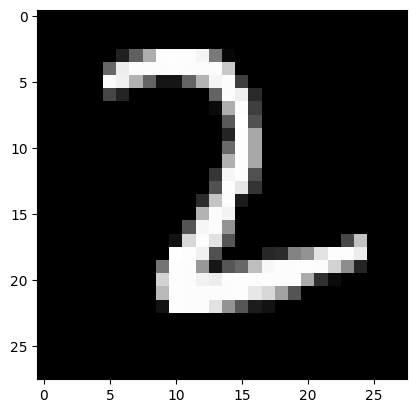

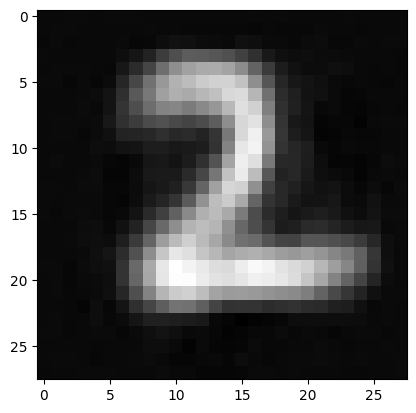

In [8]:
model.eval()

with torch.no_grad():
    import random

    index = int(random.random() * test_x.size(0))
    recon = model(test_x[index].view(1, -1)).squeeze()
    show_image(test_x[index])
    show_image(recon)

# Latent Space

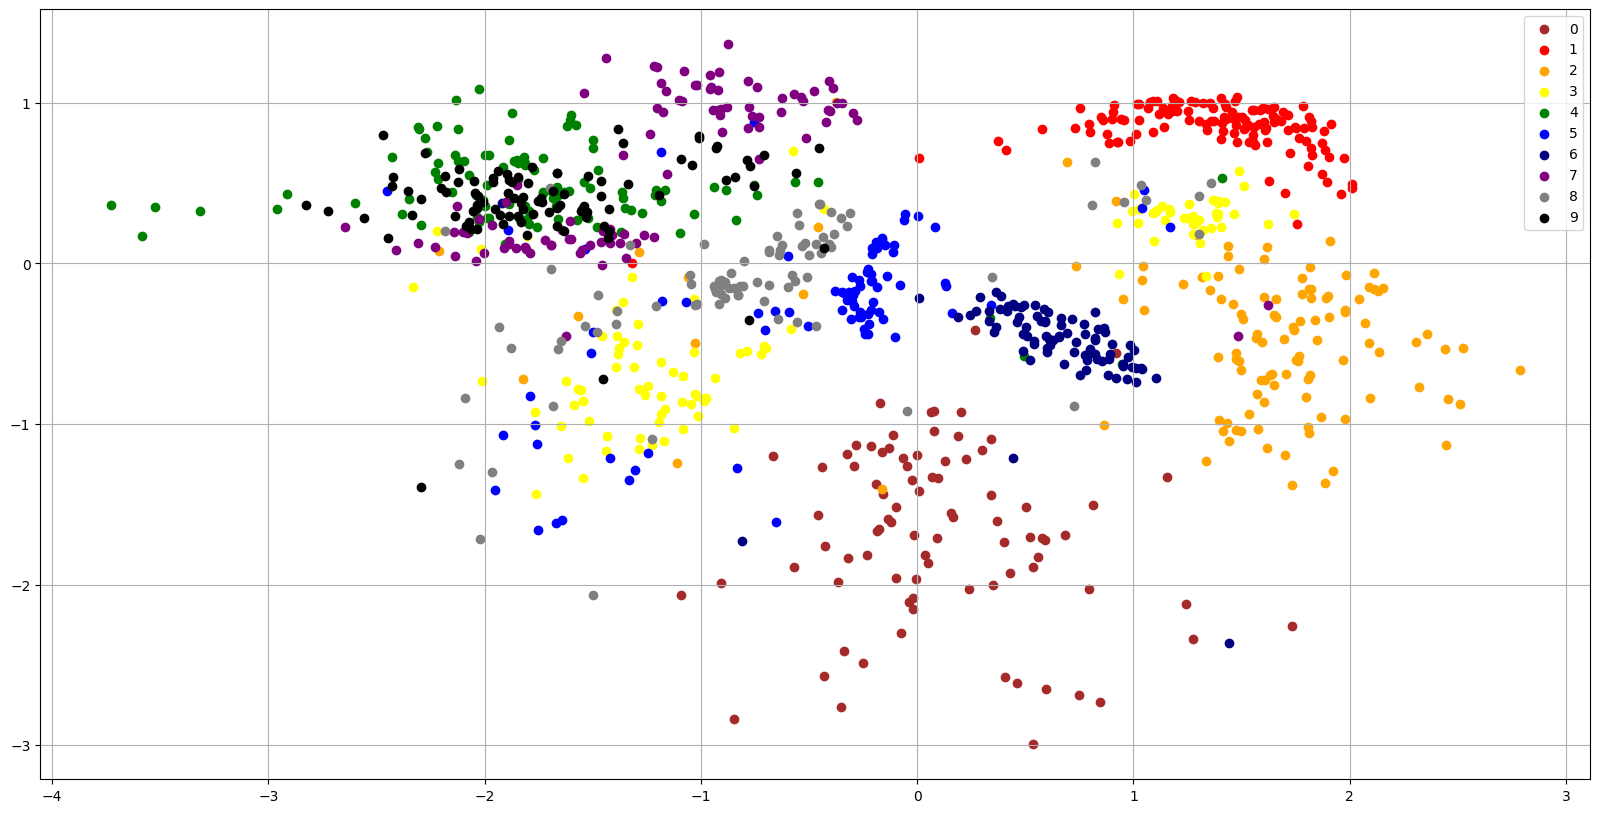

In [9]:
if config.btl_size == 2:
    color_map = [
        "brown",
        "red",
        "orange",
        "yellow",
        "green",
        "blue",
        "navy",
        "purple",
        "gray",
        "black",
    ]

    plt.figure(figsize=(20, 10))
    model.eval()
    with torch.no_grad():
        latents = model.encoder(test_x[:1000])

        for i in range(10):
            target_latents = latents[test_y[:1000] == i]
            target_y = test_y[:1000][test_y[:1000] == i]
            plt.scatter(
                target_latents[:, 0],
                target_latents[:, 1],
                marker="o",
                color=color_map[i],
                label=i,
            )
        plt.legend()
        plt.grid(axis="both")
        plt.show()

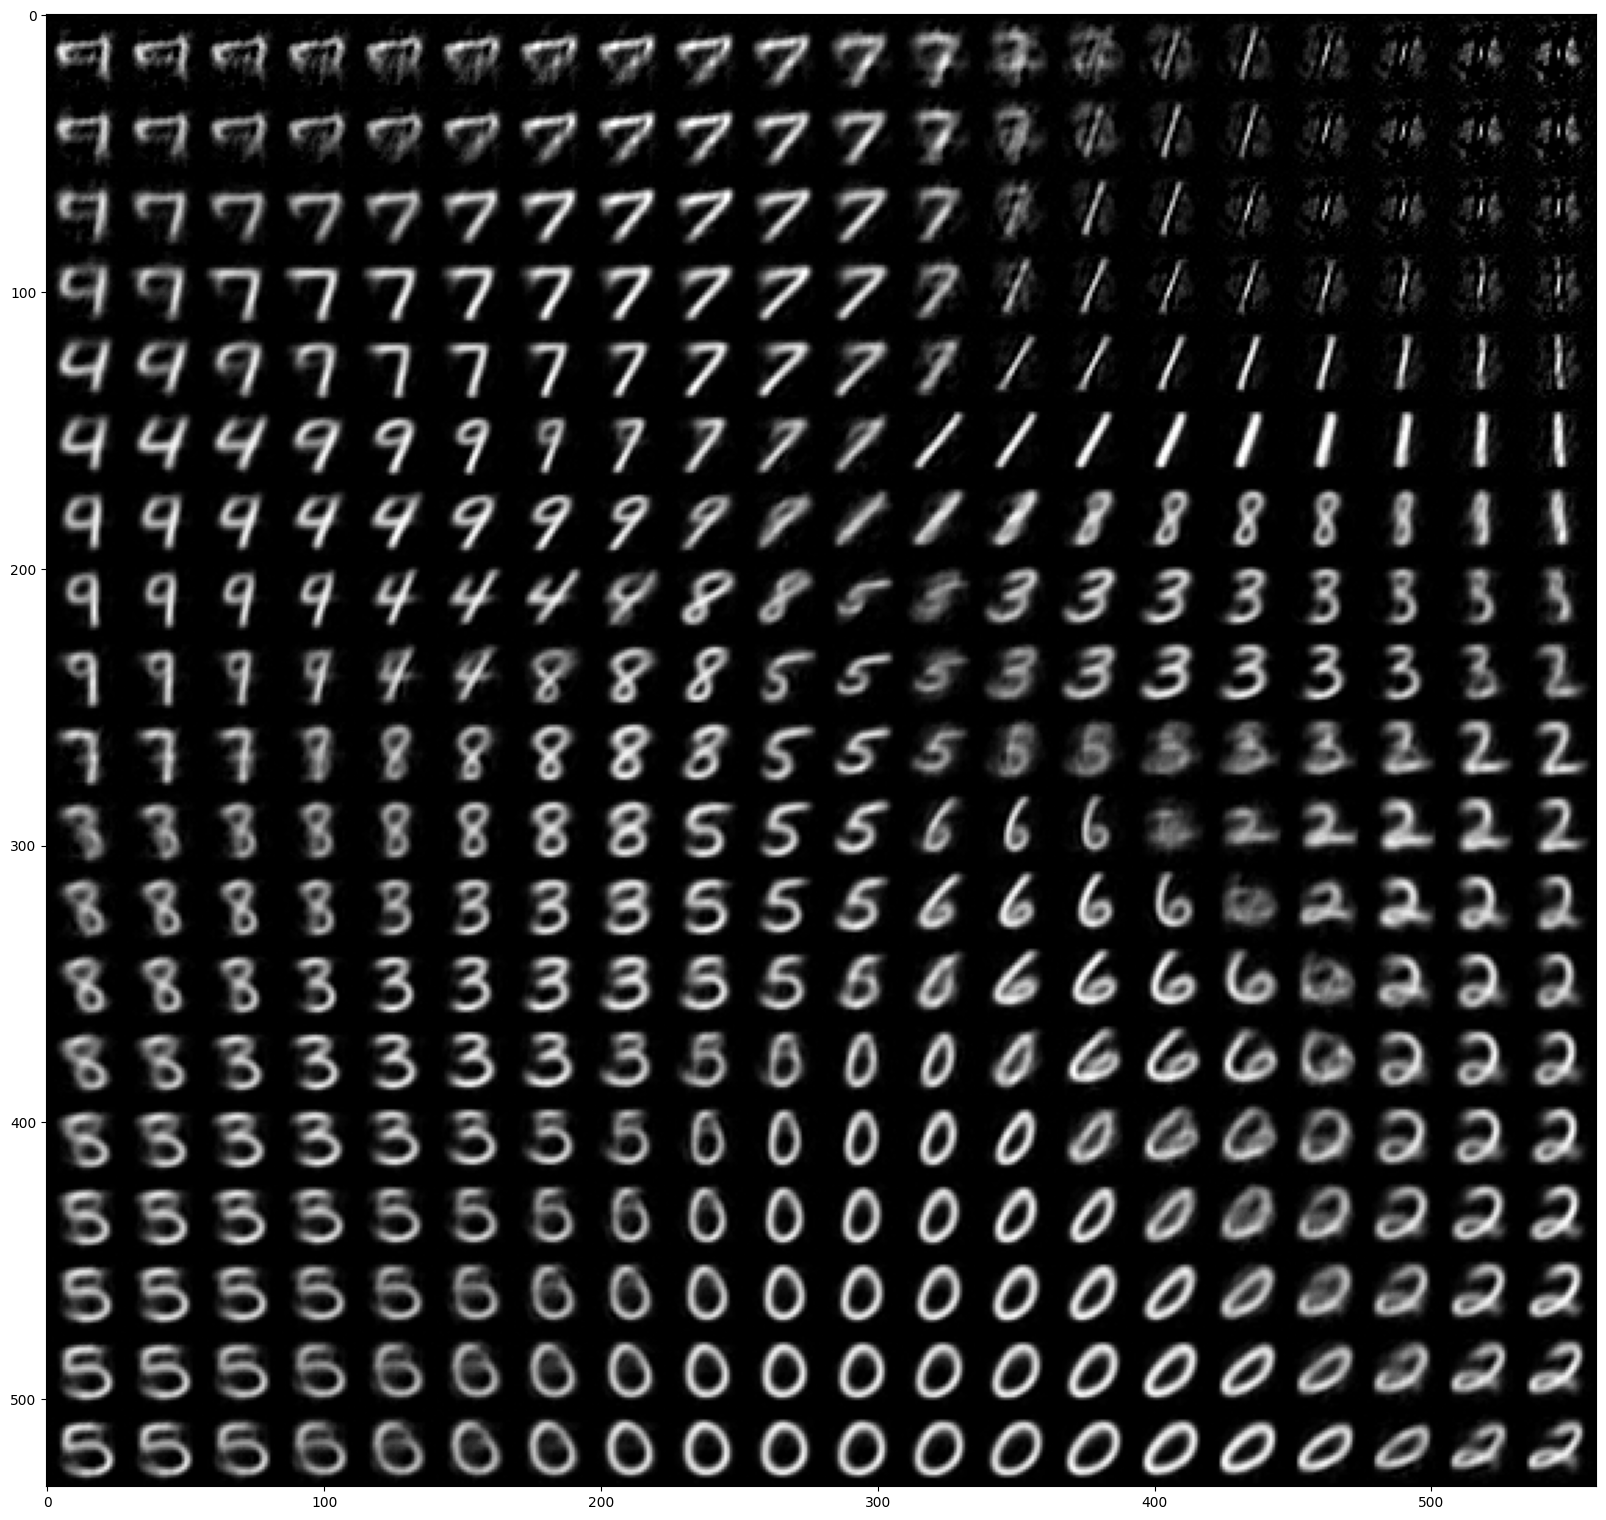

In [10]:
if config.btl_size == 2:
    min_range, max_range = -2.0, 2.0
    n = 20
    step = (max_range - min_range) / float(n)

    with torch.no_grad():
        lines = []

        for v1 in np.arange(min_range, max_range, step):
            z = torch.stack(
                [
                    torch.FloatTensor([v1] * n),
                    torch.FloatTensor(
                        [v2 for v2 in np.arange(min_range, max_range, step)]
                    ),
                ],
                dim=-1,
            )

            line = torch.clamp(model.decoder(z).view(n, 28, 28), 0, 1)
            line = torch.cat([line[i] for i in range(n - 1, 0, -1)], dim=0)
            lines += [line]

        lines = torch.cat(lines, dim=-1)
        plt.figure(figsize=(20, 20))
        show_image(lines)

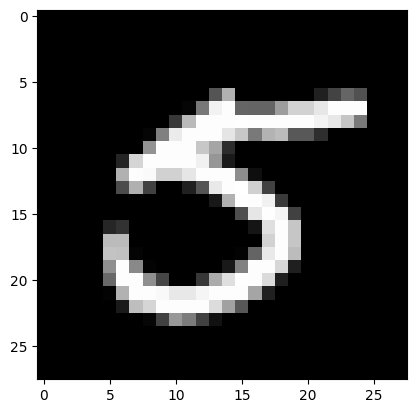

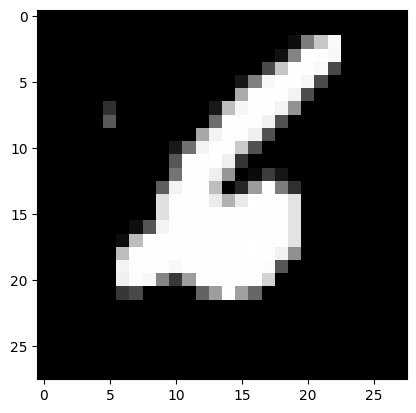

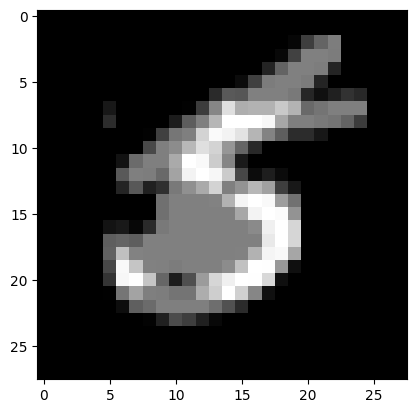

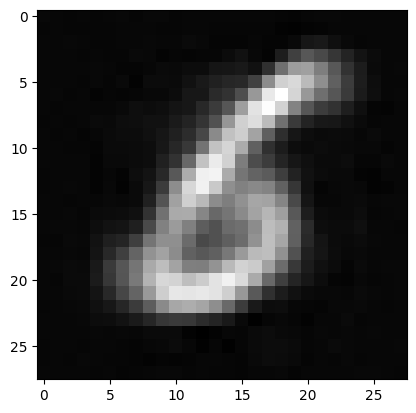

In [11]:
with torch.no_grad():
    import random

    index1 = int(random.random() * test_x.size(0))
    index2 = int(random.random() * test_x.size(0))

    z1 = model.encoder(test_x[index1].view(1, -1))
    z2 = model.encoder(test_x[index2].view(1, -1))

    recon = model.decoder((z1 + z2) / 2).squeeze()

    show_image(test_x[index1])
    show_image(test_x[index2])
    show_image((test_x[index1] + test_x[index2]) / 2)
    show_image(recon)